# Preprocessing

In [1]:
# # You may need to run those in your enviroment terminal.

#%pip install -r requirements.txt

In [76]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import spacy
import nltk
from nltk.corpus import wordnet
import random
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from datasets import Dataset
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import torch
import joblib


nltk.download('wordnet')
nltk.download('omw-1.4')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Creating data frame of the data and assigning them labels

In [77]:
texts = []
labels = []

base_path = Path('review_polarity/txt_sentoken')
pos_path = base_path / 'pos'
neg_path = base_path / 'neg'

# Assign label 1
if pos_path.exists():
    for file in pos_path.glob('*.txt'):
        with open(file, 'r', encoding = 'utf-8') as f:
            texts.append(f.read())
            labels.append(1)

# Assign label 0
if neg_path.exists():
    for file in neg_path.glob('*.txt'):
        with open(file, 'r', encoding = 'utf-8') as f:
            texts.append(f.read())
            labels.append(0)

df = pd.DataFrame({
    'label': labels,
    'text': texts
})

df.tail()

,label,text
1995,0,"if anything , "" stigmata "" should be taken as ..."
1996,0,"john boorman's "" zardoz "" is a goofy cinematic..."
1997,0,the kids in the hall are an acquired taste . \...
1998,0,there was a time when john carpenter was a gre...
1999,0,two party guys bob their heads to haddaway's d...


In [78]:
df[df.duplicated()]

,label,text


No duplicates were found

In [79]:
def spacy_pos_to_wordnet_pos(spacy_pos):
    if spacy_pos.startswith('N'):
        return wordnet.NOUN
    elif spacy_pos.startswith('V'):
        return wordnet.VERB
    elif spacy_pos.startswith('J'):
        return wordnet.ADJ
    elif spacy_pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default fallback

In [80]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    synonyms.discard(word)      # Remove the original word to avoid replacement with itself
    return list(synonyms)

In [81]:
def augment_text_with_synonyms(tokens, pos_tags, synonym_probability = 0.2):
    augmented_tokens = []

    for token, pos_tag in zip(tokens, pos_tags):
        if random.random() < synonym_probability:
            if pos_tag in ['n', 'v', 'a']:   #nouns adjectives and verbs
                synonyms = get_synonyms(token)
                if synonyms:
                    new_word = random.choice(synonyms)
                    augmented_tokens.append(new_word)
                    continue
        augmented_tokens.append(token)         # Add the original word if no augmentation is done

    return augmented_tokens

In [82]:
def apply_augmentation_to_dataset(word_tokens, pos_tags, texts, labels, sentence_tokens, synonym_probability = 0.2):
    all_word_tokens = word_tokens.copy()
    all_texts = texts.copy()  # Original text is preserved
    all_labels = labels.copy()
    all_sentence_tokens = sentence_tokens.copy()
    all_pos_tags = pos_tags.copy()

    for tokens, pos, label, sentence, text in zip(word_tokens, pos_tags, labels, sentence_tokens, texts):
        augmented_tokens = augment_text_with_synonyms(tokens, pos, synonym_probability)

        all_word_tokens.append(augmented_tokens)
        all_texts.append(text)  # Keep the original text
        all_labels.append(label)
        all_pos_tags.append(pos)
        all_sentence_tokens.append(sentence)  # Sentence tokens are not augmented

    return all_word_tokens, all_pos_tags, all_texts, all_labels, all_sentence_tokens

In [83]:
def apply_lemmatization(tokens):
    return [token.lemma_ for token in nlp(' '.join(tokens))]

In [84]:
def apply_stemming(text):

    words = text.split()
    return ' '.join([PorterStemmer().stem(word) for word in words])

In [85]:
def visualize_tf_idf_heatmap(tfidf_matrix, feature_names, n_top_features = 20, n_top_docs = 10):
    # Get the top features by summing TF-IDF scores across documents
    tfidf_array = tfidf_matrix.toarray()
    feature_importance = np.sum(tfidf_array, axis = 0)
    top_feature_indices = np.argsort(feature_importance)[-n_top_features:][::-1]
    top_features = [feature_names[i] for i in top_feature_indices]

    # Get the top documents by summing TF-IDF scores across features
    doc_importance = np.sum(tfidf_array, axis = 1)
    top_doc_indices = np.argsort(doc_importance)[-n_top_docs:][::-1]

    # Extract the submatrix for visualization
    sub_matrix = tfidf_array[np.ix_(top_doc_indices, top_feature_indices)]

    plt.figure(figsize = (12, 8))
    sns.heatmap(
        sub_matrix,
        annot = True,          # Show values in cells
        fmt = '.3f',           # Format with 3 decimal places
        cmap = 'YlGnBu',       # Better colormap
        xticklabels = top_features,
        yticklabels = range(n_top_docs)
    )
    plt.title(f'TF-IDF Heatmap (Top {n_top_features} Features, First {n_top_docs} Documents)')
    plt.xlabel('Words')
    plt.ylabel('Documents')
    plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()
    plt.savefig("Visualization\\tfidf_heatmap.png")
    plt.close()

    # Bar chart of top features across the corpus
    plt.figure(figsize = (12, 6))
    top_features_scores = [feature_importance[i] for i in top_feature_indices]
    plt.bar(top_features, top_features_scores)
    plt.title('Top TF-IDF Features Across All Documents')
    plt.xlabel('Features')
    plt.ylabel('Sum of TF-IDF Scores')
    plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()
    plt.savefig("Visualization\\tfidf_top_features.png")
    plt.close()

In [86]:
texts = df['text'].tolist()
labels = df['label'].tolist()
word_tokens = []
sentence_tokens = []
pos_tags = []

for text in texts:
    doc = nlp(text)
    sentence_tokens.append([sent.text.strip() for sent in doc.sents])
    tokens = [token for token in doc if not token.is_punct and not token.is_stop and not token.is_space]
    word_tokens.append([token.text.lower() for token in tokens])
    pos_tags.append([spacy_pos_to_wordnet_pos(token.tag_) for token in tokens])

lemmatized_tokens = [apply_lemmatization(t) for t in word_tokens]

word_tokens, pos_tags, texts, labels, sentence_tokens = apply_augmentation_to_dataset(
    lemmatized_tokens, pos_tags, texts, labels, sentence_tokens
)

joined_texts = [' '.join(tokens) for tokens in word_tokens]

augmented_df = pd.DataFrame({
    'label': labels,
    'text': joined_texts,
    'word_tokens': word_tokens
})

augmented_df = augmented_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    augmented_df['text'], augmented_df['label'], test_size=0.2, random_state=42
)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
vectorizer.fit(train_texts)
xtrain_tfidf = vectorizer.transform(train_texts)
xtest_tfidf = vectorizer.transform(test_texts)

# --- Important: Do NOT fit the vectorizer again before transforming test data! ---
tfidf_matrix = vectorizer.transform(joined_texts) 
feature_names = vectorizer.get_feature_names_out()

print(f"\nTF-IDF Matrix Shape (Train): {xtrain_tfidf.shape}")
print(f"TF-IDF Matrix Shape (Test): {xtest_tfidf.shape}")
print(f"TF-IDF Matrix Shape (Full): {tfidf_matrix.shape}") 
print(f"Number of features: {len(feature_names)}")

visualize_tf_idf_heatmap(tfidf_matrix, feature_names)

filename = "Models\\Vectorizer.joblib"
joblib.dump(vectorizer, filename)


TF-IDF Matrix Shape (Train): (3200, 41116)
TF-IDF Matrix Shape (Test): (800, 41116)
TF-IDF Matrix Shape (Full): (4000, 41116)
Number of features: 41116


['Models\\Vectorizer.joblib']

In [87]:
print("augmented_df.head():")
display(augmented_df.head())

print("\ndf.head():")
display(df.head())

augmented_df.head():


,label,text,word_tokens
0,1,harmless silly fun comedy dim witte wrestle fa...,"[harmless, silly, fun, comedy, dim, witte, wre..."
1,0,point film staging Opera go completely wrong f...,"[point, film, staging, Opera, go, completely, ..."
2,1,sick life death bob flanagan supermasochist fe...,"[sick, life, death, bob, flanagan, supermasoch..."
3,0,everybody film think alicia infotainment see c...,"[everybody, film, think, alicia, infotainment,..."
4,1,lisa cholodenko high art sound quiet dramatic_...,"[lisa, cholodenko, high, art, sound, quiet, dr..."



df.head():


,label,text
0,1,films adapted from comic books have had plenty...
1,1,every now and then a movie comes along from a ...
2,1,you've got mail works alot better than it dese...
3,1,""" jaws "" is a rare film that grabs your atten..."
4,1,moviemaking is a lot like being the general ma...


In [88]:
print("augmented_df.tail():")
display(augmented_df.tail())

print("\ndf.tail():")
display(df.tail())

augmented_df.tail():


,label,text,word_tokens
3995,0,understand clich hell earth truly mean recentl...,"[understand, clich, hell, earth, truly, mean, ..."
3996,0,1954 japanese monster film godzilla transform ...,"[1954, japanese, monster, film, godzilla, tran..."
3997,1,verdict spine chilling drama horror maestro st...,"[verdict, spine, chilling, drama, horror, maes..."
3998,0,midway Eunectes_murinus documentary filmmaker ...,"[midway, Eunectes_murinus, documentary, filmma..."
3999,0,starship trooper bad moving_picture mean uncol...,"[starship, trooper, bad, moving_picture, mean,..."



df.tail():


,label,text
1995,0,"if anything , "" stigmata "" should be taken as ..."
1996,0,"john boorman's "" zardoz "" is a goofy cinematic..."
1997,0,the kids in the hall are an acquired taste . \...
1998,0,there was a time when john carpenter was a gre...
1999,0,two party guys bob their heads to haddaway's d...


In [89]:
print("\ndf info:")
display(df.info())

print("\naugmented_df info:")
display(augmented_df.info())


df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2000 non-null   int64 
 1   text    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None


augmented_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        4000 non-null   int64 
 1   text         4000 non-null   object
 2   word_tokens  4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.9+ KB


None

In [90]:
print("\ndf dimentions:")
display(df.shape)

print("\naugmented_df dimentions:")
display(augmented_df.shape)


df dimentions:


(2000, 2)


augmented_df dimentions:


(4000, 3)

# Visualizations

In [91]:
tf = augmented_df["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.head()

,index,0
0,movie,12712.0
1,platt,62.0
2,film,20313.0
3,king,507.0
4,champion,106.0


In [92]:
# fix the column names
tf.columns = ["words", "tf"]

In [93]:
# to see the most frequent words
tf.sort_values("tf", ascending=False)

,words,tf
2,film,20313.0
0,movie,12712.0
157,like,7182.0
163,character,7039.0
11,good,6342.0
...,...,...
7325,chiller,1.0
36711,due_date,1.0
36699,transportation_system,1.0
36688,squirrel_away,1.0


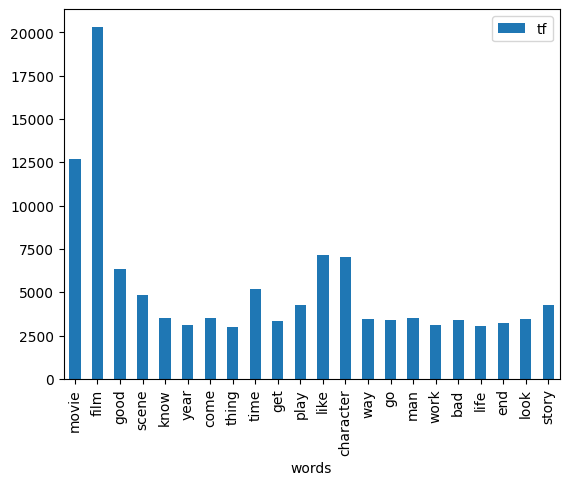

In [94]:
tf[tf["tf"] > 3000].plot.bar(x="words", y="tf")
plt.show()

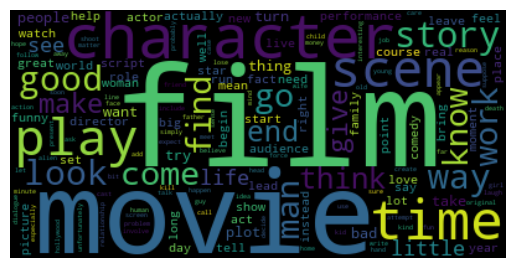

In [95]:
from wordcloud import WordCloud
# check every row and join with these with a space
text = " ".join(i for i in augmented_df.text)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Modelling - Classifiers

####        •    ML -> Logistic Regression, Naive Bayes, SVM, Decision tree, and Random Forest.

In [96]:
def train_model(classifier, feature_vector_train, train_labels, feature_vector_test, test_labels, is_neural_net=False):
    classifier.fit(feature_vector_train, train_labels)

    train_predictions = classifier.predict(feature_vector_train)
    test_predictions = classifier.predict(feature_vector_test)
    train_accuracy = metrics.accuracy_score(train_labels, train_predictions)
    test_accuracy = metrics.accuracy_score(test_labels, test_predictions)

    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    return test_accuracy  # Return the test accuracy

#### 1. Logistic Regression

In [97]:
model_l1 = linear_model.LogisticRegression(penalty='l1', C=0.7, solver='liblinear', random_state=42)
model_l1.fit(xtrain_tfidf, train_labels)

accuracy = train_model(model_l1, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename_l1 = r"Models\LR_L1.joblib"
joblib.dump(model_l1, filename_l1)

with open(r"Accuracies\LR_L1.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 79.47%
Test Accuracy: 77.88%


In [98]:
model_l2 = linear_model.LogisticRegression(penalty='l2', C=0.7, solver='liblinear', random_state=42)
model_l2.fit(xtrain_tfidf, train_labels)

accuracy = train_model(model_l2, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename_l2 = r"Models\LR_L2.joblib"
joblib.dump(model_l2, filename_l2)

with open(r"Accuracies\LR_L2.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 97.50%
Test Accuracy: 91.25%


#### 2. Naive Bayes

In [99]:
model = naive_bayes.MultinomialNB(alpha=0.7)
accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename = "Models\\NB.joblib"
joblib.dump(model, filename)

with open("Accuracies\\NB.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 97.25%
Test Accuracy: 90.75%


#### 3. SVM

In [100]:
model = svm.SVC(kernel='linear', C=0.3)
accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename = "Models\\SVM_Linear.joblib"
joblib.dump(model, filename)

with open("Accuracies\\SVM_Linear.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 96.47%
Test Accuracy: 90.75%


In [101]:
model = svm.SVC(kernel='rbf', C=0.3)
model.fit(xtrain_tfidf, train_labels)

accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

joblib.dump(model, r"Models\SVM_rbf.joblib")

with open(r"Accuracies\SVM_rbf.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 98.50%
Test Accuracy: 90.12%


In [102]:
model = svm.SVC(kernel='poly', C=0.3, degree=4)
accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename = "Models\\SVM_Poly.joblib"
joblib.dump(model, filename)

with open("Accuracies\\SVM_Poly.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 82.53%
Test Accuracy: 50.38%


#### 4. Decision Tree

In [103]:
model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=3, random_state=42)
accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename = "Models\\DT.joblib"
joblib.dump(model, filename)

with open("Accuracies\\DT.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 89.12%
Test Accuracy: 75.25%


#### 5. Random Forest

In [104]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)

accuracy = train_model(model, xtrain_tfidf, train_labels, xtest_tfidf, test_labels)

filename = "Models\\RF.joblib"
joblib.dump(model, filename)

with open("Accuracies\\RF.txt", "w") as file:
    file.write(str(accuracy * 100))

Train Accuracy: 95.56%
Test Accuracy: 84.62%


In [105]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(name, model, X_test, y_test):
    try:
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted Label (0=Negative, 1=Positive)')
        plt.ylabel('True Label (0=Negative, 1=Positive)')
        plt.tight_layout()

        sanitized_name = name.replace(' ', '_').replace('(', '').replace(')', '')
        plt.savefig(f'Visualization/confusion_matrix_{sanitized_name}.png')
        plt.show()
    except Exception as e:
        print(f"Error generating confusion matrix for {name}: {str(e)}")


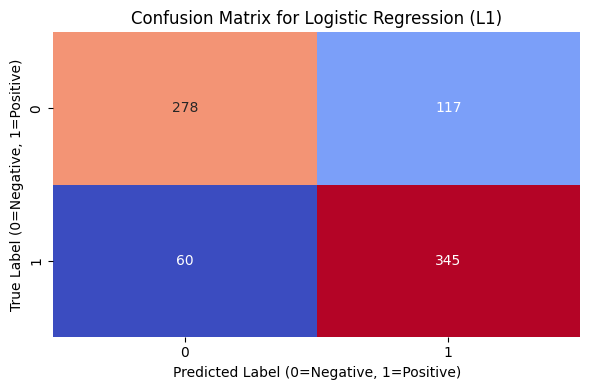

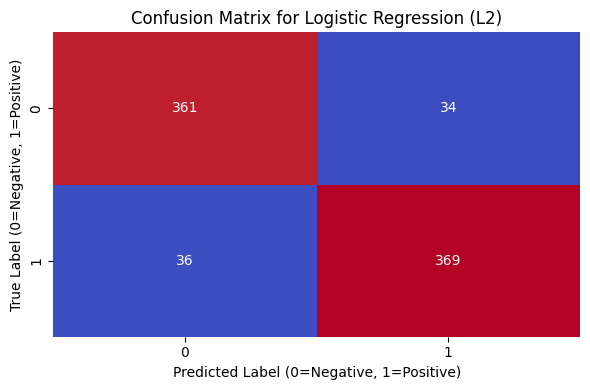

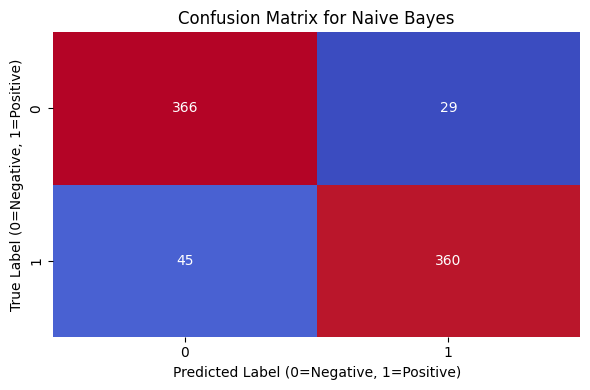

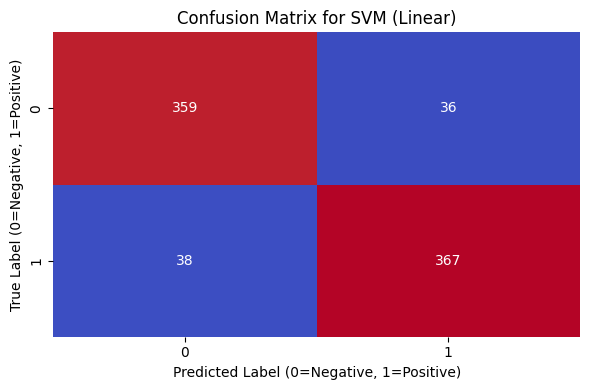

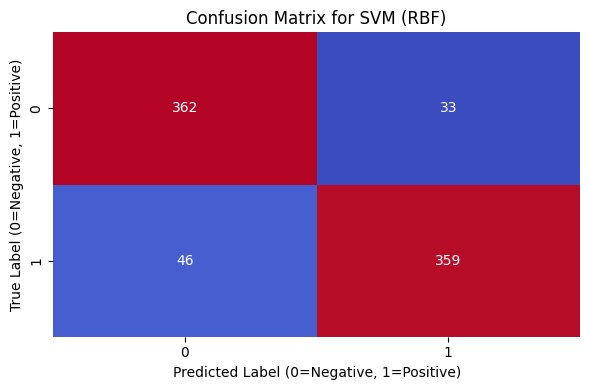

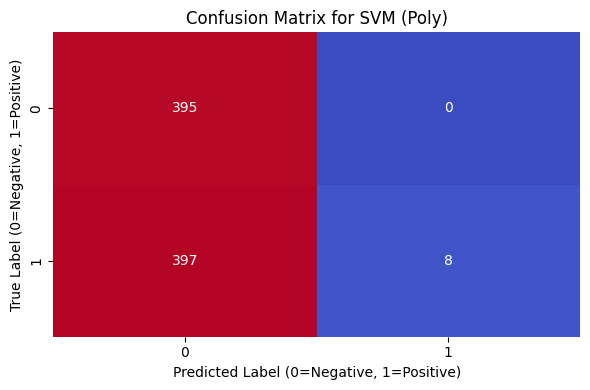

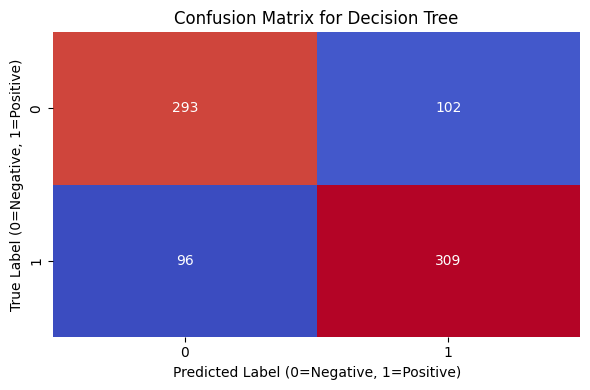

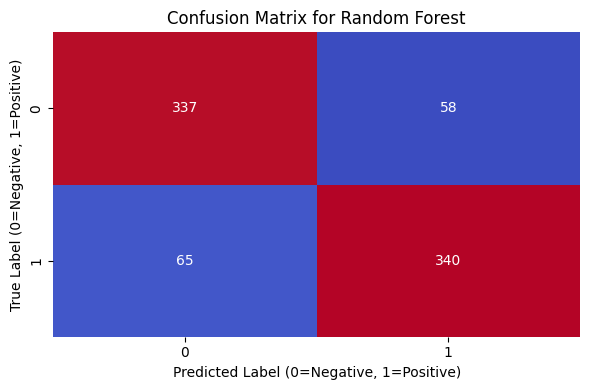

In [106]:
models = {
    'Logistic Regression (L1)': joblib.load('Models/LR_L1.joblib'),
    'Logistic Regression (L2)': joblib.load('Models/LR_L2.joblib'),
    'Naive Bayes': joblib.load('Models/NB.joblib'),
    'SVM (Linear)': joblib.load('Models/SVM_Linear.joblib'),
    'SVM (RBF)': joblib.load('Models/SVM_rbf.joblib'),
    'SVM (Poly)': joblib.load('Models/SVM_Poly.joblib'),
    'Decision Tree': joblib.load('Models/DT.joblib'),
    'Random Forest': joblib.load('Models/RF.joblib')
}

for name, model in models.items():
    print_confusion_matrix(name, model, xtest_tfidf, test_labels)

#### • DL -> BERT

In [107]:
# Use same train/test split for BERT
bert_train_texts = train_texts.tolist()
bert_test_texts = test_texts.tolist()
bert_train_labels = train_labels.tolist()
bert_test_labels = test_labels.tolist()

bert_train_ds = Dataset.from_dict({"text": bert_train_texts, "label": bert_train_labels})
bert_test_ds = Dataset.from_dict({"text": bert_test_texts, "label": bert_test_labels})

In [37]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the datasets
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

bert_train_ds = bert_train_ds.map(tokenize_function, batched=True)
bert_test_ds = bert_test_ds.map(tokenize_function, batched=True)

# Set PyTorch format
bert_train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
bert_test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

c:\Users\Asus\.conda\envs\NLP\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Asus\.conda\envs\NLP\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In or

In [38]:
# Load pre-trained BERT for classification
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Define evaluation metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

c:\Users\Asus\.conda\envs\NLP\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

In [39]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=bert_train_ds,
    eval_dataset=bert_test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

  1%|          | 10/1600 [00:36<1:34:19,  3.56s/it]

{'loss': 0.6866, 'learning_rate': 4.96875e-05, 'epoch': 0.01}


  1%|▏         | 20/1600 [01:11<1:33:08,  3.54s/it]

{'loss': 0.7465, 'learning_rate': 4.937500000000001e-05, 'epoch': 0.03}


  2%|▏         | 30/1600 [01:46<1:32:16,  3.53s/it]

{'loss': 0.6664, 'learning_rate': 4.90625e-05, 'epoch': 0.04}


  2%|▎         | 40/1600 [02:21<1:31:49,  3.53s/it]

{'loss': 0.719, 'learning_rate': 4.875e-05, 'epoch': 0.05}


  3%|▎         | 50/1600 [02:56<1:31:16,  3.53s/it]

{'loss': 0.6895, 'learning_rate': 4.8437500000000005e-05, 'epoch': 0.06}


  4%|▍         | 60/1600 [03:31<1:29:32,  3.49s/it]

{'loss': 0.7423, 'learning_rate': 4.8125000000000004e-05, 'epoch': 0.07}


  4%|▍         | 70/1600 [04:06<1:28:18,  3.46s/it]

{'loss': 0.6844, 'learning_rate': 4.7812500000000003e-05, 'epoch': 0.09}


  5%|▌         | 80/1600 [04:41<1:31:26,  3.61s/it]

{'loss': 0.7104, 'learning_rate': 4.75e-05, 'epoch': 0.1}


  6%|▌         | 90/1600 [05:19<1:30:45,  3.61s/it]

{'loss': 0.7046, 'learning_rate': 4.71875e-05, 'epoch': 0.11}


  6%|▋         | 100/1600 [05:54<1:29:01,  3.56s/it]

{'loss': 0.6975, 'learning_rate': 4.6875e-05, 'epoch': 0.12}


  7%|▋         | 110/1600 [06:30<1:27:49,  3.54s/it]

{'loss': 0.6679, 'learning_rate': 4.65625e-05, 'epoch': 0.14}


  8%|▊         | 120/1600 [07:05<1:27:35,  3.55s/it]

{'loss': 0.6928, 'learning_rate': 4.6250000000000006e-05, 'epoch': 0.15}


  8%|▊         | 130/1600 [07:41<1:26:58,  3.55s/it]

{'loss': 0.6989, 'learning_rate': 4.59375e-05, 'epoch': 0.16}


  9%|▉         | 140/1600 [08:16<1:27:21,  3.59s/it]

{'loss': 0.7068, 'learning_rate': 4.5625e-05, 'epoch': 0.17}


  9%|▉         | 150/1600 [08:52<1:26:29,  3.58s/it]

{'loss': 0.7086, 'learning_rate': 4.5312500000000004e-05, 'epoch': 0.19}


 10%|█         | 160/1600 [09:28<1:25:59,  3.58s/it]

{'loss': 0.7172, 'learning_rate': 4.5e-05, 'epoch': 0.2}


 11%|█         | 170/1600 [10:04<1:26:04,  3.61s/it]

{'loss': 0.6754, 'learning_rate': 4.46875e-05, 'epoch': 0.21}


 11%|█▏        | 180/1600 [10:40<1:24:59,  3.59s/it]

{'loss': 0.7118, 'learning_rate': 4.4375e-05, 'epoch': 0.23}


 12%|█▏        | 190/1600 [11:16<1:24:08,  3.58s/it]

{'loss': 0.7022, 'learning_rate': 4.40625e-05, 'epoch': 0.24}


 12%|█▎        | 200/1600 [11:52<1:23:33,  3.58s/it]

{'loss': 0.7561, 'learning_rate': 4.375e-05, 'epoch': 0.25}


 13%|█▎        | 210/1600 [12:28<1:24:26,  3.65s/it]

{'loss': 0.6949, 'learning_rate': 4.3437500000000006e-05, 'epoch': 0.26}


 14%|█▍        | 220/1600 [13:04<1:22:59,  3.61s/it]

{'loss': 0.7887, 'learning_rate': 4.3125000000000005e-05, 'epoch': 0.28}


 14%|█▍        | 230/1600 [13:40<1:22:55,  3.63s/it]

{'loss': 0.6957, 'learning_rate': 4.28125e-05, 'epoch': 0.29}


 15%|█▌        | 240/1600 [14:17<1:21:48,  3.61s/it]

{'loss': 0.6996, 'learning_rate': 4.25e-05, 'epoch': 0.3}


 16%|█▌        | 250/1600 [14:53<1:20:34,  3.58s/it]

{'loss': 0.6861, 'learning_rate': 4.21875e-05, 'epoch': 0.31}


 16%|█▋        | 260/1600 [15:29<1:20:33,  3.61s/it]

{'loss': 0.7045, 'learning_rate': 4.1875e-05, 'epoch': 0.33}


 17%|█▋        | 270/1600 [16:05<1:19:37,  3.59s/it]

{'loss': 0.771, 'learning_rate': 4.156250000000001e-05, 'epoch': 0.34}


 18%|█▊        | 280/1600 [16:41<1:20:13,  3.65s/it]

{'loss': 0.6977, 'learning_rate': 4.125e-05, 'epoch': 0.35}


 18%|█▊        | 290/1600 [17:17<1:17:48,  3.56s/it]

{'loss': 0.7117, 'learning_rate': 4.09375e-05, 'epoch': 0.36}


 19%|█▉        | 300/1600 [17:52<1:17:23,  3.57s/it]

{'loss': 0.7049, 'learning_rate': 4.0625000000000005e-05, 'epoch': 0.38}


 19%|█▉        | 310/1600 [18:27<1:15:11,  3.50s/it]

{'loss': 0.6811, 'learning_rate': 4.0312500000000004e-05, 'epoch': 0.39}


 20%|██        | 320/1600 [19:02<1:15:03,  3.52s/it]

{'loss': 0.7453, 'learning_rate': 4e-05, 'epoch': 0.4}


 21%|██        | 330/1600 [19:38<1:15:25,  3.56s/it]

{'loss': 0.6986, 'learning_rate': 3.96875e-05, 'epoch': 0.41}


 21%|██▏       | 340/1600 [20:13<1:14:03,  3.53s/it]

{'loss': 0.6929, 'learning_rate': 3.9375e-05, 'epoch': 0.42}


 22%|██▏       | 350/1600 [20:49<1:14:55,  3.60s/it]

{'loss': 0.6878, 'learning_rate': 3.90625e-05, 'epoch': 0.44}


 22%|██▎       | 360/1600 [21:25<1:13:45,  3.57s/it]

{'loss': 0.6754, 'learning_rate': 3.875e-05, 'epoch': 0.45}


 23%|██▎       | 370/1600 [22:00<1:12:05,  3.52s/it]

{'loss': 0.7286, 'learning_rate': 3.8437500000000006e-05, 'epoch': 0.46}


 24%|██▍       | 380/1600 [22:35<1:11:01,  3.49s/it]

{'loss': 0.6966, 'learning_rate': 3.8125e-05, 'epoch': 0.47}


 24%|██▍       | 390/1600 [23:10<1:10:55,  3.52s/it]

{'loss': 0.7418, 'learning_rate': 3.78125e-05, 'epoch': 0.49}


 25%|██▌       | 400/1600 [23:46<1:11:50,  3.59s/it]

{'loss': 0.6991, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.5}


 26%|██▌       | 410/1600 [24:21<1:10:42,  3.57s/it]

{'loss': 0.7157, 'learning_rate': 3.71875e-05, 'epoch': 0.51}


 26%|██▋       | 420/1600 [24:57<1:10:24,  3.58s/it]

{'loss': 0.7356, 'learning_rate': 3.6875e-05, 'epoch': 0.53}


 27%|██▋       | 430/1600 [25:33<1:09:30,  3.56s/it]

{'loss': 0.6828, 'learning_rate': 3.65625e-05, 'epoch': 0.54}


 28%|██▊       | 440/1600 [26:09<1:09:06,  3.57s/it]

{'loss': 0.6867, 'learning_rate': 3.625e-05, 'epoch': 0.55}


 28%|██▊       | 450/1600 [26:45<1:08:06,  3.55s/it]

{'loss': 0.7068, 'learning_rate': 3.59375e-05, 'epoch': 0.56}


 29%|██▉       | 460/1600 [27:25<1:16:22,  4.02s/it]

{'loss': 0.703, 'learning_rate': 3.5625000000000005e-05, 'epoch': 0.57}


 29%|██▉       | 470/1600 [28:01<1:07:47,  3.60s/it]

{'loss': 0.6708, 'learning_rate': 3.5312500000000005e-05, 'epoch': 0.59}


 30%|███       | 480/1600 [28:36<1:06:47,  3.58s/it]

{'loss': 0.6943, 'learning_rate': 3.5e-05, 'epoch': 0.6}


 31%|███       | 490/1600 [29:12<1:06:43,  3.61s/it]

{'loss': 0.6587, 'learning_rate': 3.46875e-05, 'epoch': 0.61}


 31%|███▏      | 500/1600 [29:48<1:05:44,  3.59s/it]

{'loss': 0.731, 'learning_rate': 3.4375e-05, 'epoch': 0.62}


 32%|███▏      | 510/1600 [30:24<1:05:21,  3.60s/it]

{'loss': 0.7145, 'learning_rate': 3.40625e-05, 'epoch': 0.64}


 32%|███▎      | 520/1600 [31:00<1:04:27,  3.58s/it]

{'loss': 0.6946, 'learning_rate': 3.375000000000001e-05, 'epoch': 0.65}


 33%|███▎      | 530/1600 [31:36<1:03:45,  3.58s/it]

{'loss': 0.6639, 'learning_rate': 3.34375e-05, 'epoch': 0.66}


 34%|███▍      | 540/1600 [32:12<1:03:33,  3.60s/it]

{'loss': 0.706, 'learning_rate': 3.3125e-05, 'epoch': 0.68}


 34%|███▍      | 550/1600 [32:47<1:02:39,  3.58s/it]

{'loss': 0.6671, 'learning_rate': 3.2812500000000005e-05, 'epoch': 0.69}


 35%|███▌      | 560/1600 [33:23<1:02:10,  3.59s/it]

{'loss': 0.7006, 'learning_rate': 3.2500000000000004e-05, 'epoch': 0.7}


 36%|███▌      | 570/1600 [33:59<1:01:36,  3.59s/it]

{'loss': 0.694, 'learning_rate': 3.21875e-05, 'epoch': 0.71}


 36%|███▋      | 580/1600 [34:35<1:00:47,  3.58s/it]

{'loss': 0.7131, 'learning_rate': 3.1875e-05, 'epoch': 0.72}


 37%|███▋      | 590/1600 [35:11<1:00:19,  3.58s/it]

{'loss': 0.6905, 'learning_rate': 3.15625e-05, 'epoch': 0.74}


 38%|███▊      | 600/1600 [35:47<59:39,  3.58s/it]  

{'loss': 0.7021, 'learning_rate': 3.125e-05, 'epoch': 0.75}


 38%|███▊      | 610/1600 [36:22<58:51,  3.57s/it]

{'loss': 0.7615, 'learning_rate': 3.09375e-05, 'epoch': 0.76}


 39%|███▉      | 620/1600 [36:58<58:38,  3.59s/it]

{'loss': 0.6955, 'learning_rate': 3.0625000000000006e-05, 'epoch': 0.78}


 39%|███▉      | 630/1600 [37:34<57:50,  3.58s/it]

{'loss': 0.705, 'learning_rate': 3.0312499999999998e-05, 'epoch': 0.79}


 40%|████      | 640/1600 [38:09<57:04,  3.57s/it]

{'loss': 0.7051, 'learning_rate': 3e-05, 'epoch': 0.8}


 41%|████      | 650/1600 [38:45<56:51,  3.59s/it]

{'loss': 0.6833, 'learning_rate': 2.96875e-05, 'epoch': 0.81}


 41%|████▏     | 660/1600 [39:21<56:07,  3.58s/it]

{'loss': 0.6832, 'learning_rate': 2.9375000000000003e-05, 'epoch': 0.82}


 42%|████▏     | 670/1600 [39:57<55:28,  3.58s/it]

{'loss': 0.6722, 'learning_rate': 2.9062500000000005e-05, 'epoch': 0.84}


 42%|████▎     | 680/1600 [40:33<54:44,  3.57s/it]

{'loss': 0.7712, 'learning_rate': 2.8749999999999997e-05, 'epoch': 0.85}


 43%|████▎     | 690/1600 [41:09<54:15,  3.58s/it]

{'loss': 0.7103, 'learning_rate': 2.84375e-05, 'epoch': 0.86}


 44%|████▍     | 700/1600 [41:44<53:36,  3.57s/it]

{'loss': 0.7402, 'learning_rate': 2.8125000000000003e-05, 'epoch': 0.88}


 44%|████▍     | 710/1600 [42:24<1:02:26,  4.21s/it]

{'loss': 0.7077, 'learning_rate': 2.7812500000000002e-05, 'epoch': 0.89}


 45%|████▌     | 720/1600 [43:07<1:03:08,  4.30s/it]

{'loss': 0.6731, 'learning_rate': 2.7500000000000004e-05, 'epoch': 0.9}


 46%|████▌     | 730/1600 [43:50<1:02:20,  4.30s/it]

{'loss': 0.6184, 'learning_rate': 2.71875e-05, 'epoch': 0.91}


 46%|████▋     | 740/1600 [44:33<1:01:21,  4.28s/it]

{'loss': 0.7021, 'learning_rate': 2.6875e-05, 'epoch': 0.93}


 47%|████▋     | 750/1600 [45:16<1:00:56,  4.30s/it]

{'loss': 0.5005, 'learning_rate': 2.6562500000000002e-05, 'epoch': 0.94}


 48%|████▊     | 760/1600 [45:59<1:00:15,  4.30s/it]

{'loss': 0.7026, 'learning_rate': 2.625e-05, 'epoch': 0.95}


 48%|████▊     | 770/1600 [46:42<59:31,  4.30s/it]  

{'loss': 0.7464, 'learning_rate': 2.5937500000000004e-05, 'epoch': 0.96}


 49%|████▉     | 780/1600 [47:25<58:57,  4.31s/it]

{'loss': 0.7187, 'learning_rate': 2.5625e-05, 'epoch': 0.97}


 49%|████▉     | 790/1600 [48:08<58:23,  4.33s/it]

{'loss': 0.6356, 'learning_rate': 2.53125e-05, 'epoch': 0.99}


 50%|█████     | 800/1600 [48:51<57:06,  4.28s/it]

{'loss': 0.6805, 'learning_rate': 2.5e-05, 'epoch': 1.0}


                                                  
 50%|█████     | 800/1600 [53:16<57:06,  4.28s/it]

{'eval_loss': 0.6284638047218323, 'eval_accuracy': 0.70125, 'eval_runtime': 265.3717, 'eval_samples_per_second': 3.015, 'eval_steps_per_second': 0.754, 'epoch': 1.0}


 51%|█████     | 810/1600 [54:00<1:38:58,  7.52s/it] 

{'loss': 0.4909, 'learning_rate': 2.4687500000000004e-05, 'epoch': 1.01}


 51%|█████▏    | 820/1600 [54:43<57:18,  4.41s/it]  

{'loss': 0.5075, 'learning_rate': 2.4375e-05, 'epoch': 1.02}


 52%|█████▏    | 830/1600 [55:26<55:06,  4.29s/it]

{'loss': 0.8727, 'learning_rate': 2.4062500000000002e-05, 'epoch': 1.04}


 52%|█████▎    | 840/1600 [56:09<54:29,  4.30s/it]

{'loss': 0.7546, 'learning_rate': 2.375e-05, 'epoch': 1.05}


 53%|█████▎    | 850/1600 [56:52<53:50,  4.31s/it]

{'loss': 0.6648, 'learning_rate': 2.34375e-05, 'epoch': 1.06}


 54%|█████▍    | 860/1600 [57:35<53:13,  4.31s/it]

{'loss': 0.5734, 'learning_rate': 2.3125000000000003e-05, 'epoch': 1.07}


 54%|█████▍    | 870/1600 [58:18<52:35,  4.32s/it]

{'loss': 0.5777, 'learning_rate': 2.28125e-05, 'epoch': 1.09}


 55%|█████▌    | 880/1600 [59:01<51:56,  4.33s/it]

{'loss': 0.6713, 'learning_rate': 2.25e-05, 'epoch': 1.1}


 56%|█████▌    | 890/1600 [59:45<51:23,  4.34s/it]

{'loss': 0.5506, 'learning_rate': 2.21875e-05, 'epoch': 1.11}


 56%|█████▋    | 900/1600 [1:00:28<49:59,  4.29s/it]

{'loss': 0.5632, 'learning_rate': 2.1875e-05, 'epoch': 1.12}


 57%|█████▋    | 910/1600 [1:01:11<49:29,  4.30s/it]

{'loss': 0.4133, 'learning_rate': 2.1562500000000002e-05, 'epoch': 1.14}


 57%|█████▊    | 920/1600 [1:01:53<48:40,  4.29s/it]

{'loss': 0.5577, 'learning_rate': 2.125e-05, 'epoch': 1.15}


 58%|█████▊    | 930/1600 [1:02:37<48:01,  4.30s/it]

{'loss': 0.6622, 'learning_rate': 2.09375e-05, 'epoch': 1.16}


 59%|█████▉    | 940/1600 [1:03:19<47:14,  4.29s/it]

{'loss': 0.6378, 'learning_rate': 2.0625e-05, 'epoch': 1.18}


 59%|█████▉    | 950/1600 [1:04:03<46:41,  4.31s/it]

{'loss': 0.5793, 'learning_rate': 2.0312500000000002e-05, 'epoch': 1.19}


 60%|██████    | 960/1600 [1:04:45<45:58,  4.31s/it]

{'loss': 0.6256, 'learning_rate': 2e-05, 'epoch': 1.2}


 61%|██████    | 970/1600 [1:05:29<45:32,  4.34s/it]

{'loss': 0.6012, 'learning_rate': 1.96875e-05, 'epoch': 1.21}


 61%|██████▏   | 980/1600 [1:06:12<44:39,  4.32s/it]

{'loss': 0.3865, 'learning_rate': 1.9375e-05, 'epoch': 1.23}


 62%|██████▏   | 990/1600 [1:06:55<43:42,  4.30s/it]

{'loss': 0.4786, 'learning_rate': 1.90625e-05, 'epoch': 1.24}


 62%|██████▎   | 1000/1600 [1:07:38<43:03,  4.31s/it]

{'loss': 0.5381, 'learning_rate': 1.8750000000000002e-05, 'epoch': 1.25}


 63%|██████▎   | 1010/1600 [1:08:21<42:15,  4.30s/it]

{'loss': 0.514, 'learning_rate': 1.84375e-05, 'epoch': 1.26}


 64%|██████▍   | 1020/1600 [1:09:04<41:43,  4.32s/it]

{'loss': 0.379, 'learning_rate': 1.8125e-05, 'epoch': 1.27}


 64%|██████▍   | 1030/1600 [1:09:47<41:04,  4.32s/it]

{'loss': 0.5633, 'learning_rate': 1.7812500000000003e-05, 'epoch': 1.29}


 65%|██████▌   | 1040/1600 [1:10:31<40:09,  4.30s/it]

{'loss': 0.6045, 'learning_rate': 1.75e-05, 'epoch': 1.3}


 66%|██████▌   | 1050/1600 [1:11:14<39:37,  4.32s/it]

{'loss': 0.6419, 'learning_rate': 1.71875e-05, 'epoch': 1.31}


 66%|██████▋   | 1060/1600 [1:11:57<38:41,  4.30s/it]

{'loss': 0.3479, 'learning_rate': 1.6875000000000004e-05, 'epoch': 1.32}


 67%|██████▋   | 1070/1600 [1:12:40<37:59,  4.30s/it]

{'loss': 0.3971, 'learning_rate': 1.65625e-05, 'epoch': 1.34}


 68%|██████▊   | 1080/1600 [1:13:23<37:19,  4.31s/it]

{'loss': 0.4391, 'learning_rate': 1.6250000000000002e-05, 'epoch': 1.35}


 68%|██████▊   | 1090/1600 [1:14:06<36:55,  4.34s/it]

{'loss': 0.4199, 'learning_rate': 1.59375e-05, 'epoch': 1.36}


 69%|██████▉   | 1100/1600 [1:14:49<36:02,  4.33s/it]

{'loss': 0.4942, 'learning_rate': 1.5625e-05, 'epoch': 1.38}


 69%|██████▉   | 1110/1600 [1:15:26<29:23,  3.60s/it]

{'loss': 0.6808, 'learning_rate': 1.5312500000000003e-05, 'epoch': 1.39}


 70%|███████   | 1120/1600 [1:16:01<28:33,  3.57s/it]

{'loss': 0.7137, 'learning_rate': 1.5e-05, 'epoch': 1.4}


 71%|███████   | 1130/1600 [1:16:37<28:08,  3.59s/it]

{'loss': 0.5438, 'learning_rate': 1.4687500000000001e-05, 'epoch': 1.41}


 71%|███████▏  | 1140/1600 [1:17:13<27:36,  3.60s/it]

{'loss': 0.6351, 'learning_rate': 1.4374999999999999e-05, 'epoch': 1.43}


 72%|███████▏  | 1150/1600 [1:17:49<26:56,  3.59s/it]

{'loss': 0.3048, 'learning_rate': 1.4062500000000001e-05, 'epoch': 1.44}


 72%|███████▎  | 1160/1600 [1:18:25<26:21,  3.59s/it]

{'loss': 0.6182, 'learning_rate': 1.3750000000000002e-05, 'epoch': 1.45}


 73%|███████▎  | 1170/1600 [1:19:01<25:47,  3.60s/it]

{'loss': 0.6336, 'learning_rate': 1.34375e-05, 'epoch': 1.46}


 74%|███████▍  | 1180/1600 [1:19:37<25:08,  3.59s/it]

{'loss': 0.5323, 'learning_rate': 1.3125e-05, 'epoch': 1.48}


 74%|███████▍  | 1190/1600 [1:20:12<24:21,  3.56s/it]

{'loss': 0.4536, 'learning_rate': 1.28125e-05, 'epoch': 1.49}


 75%|███████▌  | 1200/1600 [1:20:48<23:21,  3.50s/it]

{'loss': 0.6193, 'learning_rate': 1.25e-05, 'epoch': 1.5}


 76%|███████▌  | 1210/1600 [1:21:23<22:48,  3.51s/it]

{'loss': 0.5834, 'learning_rate': 1.21875e-05, 'epoch': 1.51}


 76%|███████▋  | 1220/1600 [1:21:58<22:18,  3.52s/it]

{'loss': 0.521, 'learning_rate': 1.1875e-05, 'epoch': 1.52}


 77%|███████▋  | 1230/1600 [1:22:34<21:50,  3.54s/it]

{'loss': 0.6152, 'learning_rate': 1.1562500000000002e-05, 'epoch': 1.54}


 78%|███████▊  | 1240/1600 [1:23:10<22:19,  3.72s/it]

{'loss': 0.4758, 'learning_rate': 1.125e-05, 'epoch': 1.55}


 78%|███████▊  | 1250/1600 [1:23:51<24:12,  4.15s/it]

{'loss': 0.393, 'learning_rate': 1.09375e-05, 'epoch': 1.56}


 79%|███████▉  | 1260/1600 [1:24:33<23:25,  4.13s/it]

{'loss': 0.2874, 'learning_rate': 1.0625e-05, 'epoch': 1.57}


 79%|███████▉  | 1270/1600 [1:25:15<22:51,  4.16s/it]

{'loss': 0.7043, 'learning_rate': 1.03125e-05, 'epoch': 1.59}


 80%|████████  | 1280/1600 [1:25:56<22:05,  4.14s/it]

{'loss': 0.6741, 'learning_rate': 1e-05, 'epoch': 1.6}


 81%|████████  | 1290/1600 [1:26:38<21:31,  4.17s/it]

{'loss': 0.3484, 'learning_rate': 9.6875e-06, 'epoch': 1.61}


 81%|████████▏ | 1300/1600 [1:27:20<20:53,  4.18s/it]

{'loss': 0.2145, 'learning_rate': 9.375000000000001e-06, 'epoch': 1.62}


 82%|████████▏ | 1310/1600 [1:28:01<19:56,  4.13s/it]

{'loss': 0.3893, 'learning_rate': 9.0625e-06, 'epoch': 1.64}


 82%|████████▎ | 1320/1600 [1:28:43<19:19,  4.14s/it]

{'loss': 0.7837, 'learning_rate': 8.75e-06, 'epoch': 1.65}


 83%|████████▎ | 1330/1600 [1:29:25<18:36,  4.14s/it]

{'loss': 0.2919, 'learning_rate': 8.437500000000002e-06, 'epoch': 1.66}


 84%|████████▍ | 1340/1600 [1:30:06<18:01,  4.16s/it]

{'loss': 0.3235, 'learning_rate': 8.125000000000001e-06, 'epoch': 1.68}


 84%|████████▍ | 1350/1600 [1:30:48<17:15,  4.14s/it]

{'loss': 0.4717, 'learning_rate': 7.8125e-06, 'epoch': 1.69}


 85%|████████▌ | 1360/1600 [1:31:29<16:35,  4.15s/it]

{'loss': 0.6101, 'learning_rate': 7.5e-06, 'epoch': 1.7}


 86%|████████▌ | 1370/1600 [1:32:11<16:10,  4.22s/it]

{'loss': 0.7307, 'learning_rate': 7.187499999999999e-06, 'epoch': 1.71}


 86%|████████▋ | 1380/1600 [1:32:53<15:20,  4.18s/it]

{'loss': 0.5235, 'learning_rate': 6.875000000000001e-06, 'epoch': 1.73}


 87%|████████▋ | 1390/1600 [1:33:35<14:45,  4.22s/it]

{'loss': 0.4211, 'learning_rate': 6.5625e-06, 'epoch': 1.74}


 88%|████████▊ | 1400/1600 [1:34:18<14:20,  4.30s/it]

{'loss': 0.6158, 'learning_rate': 6.25e-06, 'epoch': 1.75}


 88%|████████▊ | 1410/1600 [1:35:00<13:27,  4.25s/it]

{'loss': 0.3768, 'learning_rate': 5.9375e-06, 'epoch': 1.76}


 89%|████████▉ | 1420/1600 [1:35:43<12:45,  4.25s/it]

{'loss': 0.4997, 'learning_rate': 5.625e-06, 'epoch': 1.77}


 89%|████████▉ | 1430/1600 [1:36:27<12:12,  4.31s/it]

{'loss': 0.5554, 'learning_rate': 5.3125e-06, 'epoch': 1.79}


 90%|█████████ | 1440/1600 [1:37:10<11:23,  4.27s/it]

{'loss': 0.6506, 'learning_rate': 5e-06, 'epoch': 1.8}


 91%|█████████ | 1450/1600 [1:37:53<10:49,  4.33s/it]

{'loss': 0.151, 'learning_rate': 4.6875000000000004e-06, 'epoch': 1.81}


 91%|█████████▏| 1460/1600 [1:38:36<09:59,  4.28s/it]

{'loss': 0.732, 'learning_rate': 4.375e-06, 'epoch': 1.82}


 92%|█████████▏| 1470/1600 [1:39:19<09:11,  4.24s/it]

{'loss': 0.5219, 'learning_rate': 4.0625000000000005e-06, 'epoch': 1.84}


 92%|█████████▎| 1480/1600 [1:40:01<08:26,  4.22s/it]

{'loss': 0.4926, 'learning_rate': 3.75e-06, 'epoch': 1.85}


 93%|█████████▎| 1490/1600 [1:40:44<07:47,  4.25s/it]

{'loss': 0.5967, 'learning_rate': 3.4375000000000005e-06, 'epoch': 1.86}


 94%|█████████▍| 1500/1600 [1:41:25<06:50,  4.11s/it]

{'loss': 0.2905, 'learning_rate': 3.125e-06, 'epoch': 1.88}


 94%|█████████▍| 1510/1600 [1:42:06<06:04,  4.06s/it]

{'loss': 0.7928, 'learning_rate': 2.8125e-06, 'epoch': 1.89}


 95%|█████████▌| 1520/1600 [1:42:47<05:34,  4.18s/it]

{'loss': 0.3858, 'learning_rate': 2.5e-06, 'epoch': 1.9}


 96%|█████████▌| 1530/1600 [1:43:28<04:29,  3.84s/it]

{'loss': 0.5203, 'learning_rate': 2.1875e-06, 'epoch': 1.91}


 96%|█████████▋| 1540/1600 [1:44:04<03:29,  3.50s/it]

{'loss': 0.6507, 'learning_rate': 1.875e-06, 'epoch': 1.93}


 97%|█████████▋| 1550/1600 [1:44:44<03:08,  3.76s/it]

{'loss': 0.2686, 'learning_rate': 1.5625e-06, 'epoch': 1.94}


 98%|█████████▊| 1560/1600 [1:45:23<02:35,  3.89s/it]

{'loss': 0.8175, 'learning_rate': 1.25e-06, 'epoch': 1.95}


 98%|█████████▊| 1570/1600 [1:46:03<02:03,  4.12s/it]

{'loss': 0.4178, 'learning_rate': 9.375e-07, 'epoch': 1.96}


 99%|█████████▉| 1580/1600 [1:46:41<01:11,  3.59s/it]

{'loss': 0.3682, 'learning_rate': 6.25e-07, 'epoch': 1.98}


 99%|█████████▉| 1590/1600 [1:47:19<00:40,  4.01s/it]

{'loss': 0.6559, 'learning_rate': 3.125e-07, 'epoch': 1.99}


100%|██████████| 1600/1600 [1:47:58<00:00,  4.04s/it]

{'loss': 0.5922, 'learning_rate': 0.0, 'epoch': 2.0}


                                                     
100%|██████████| 1600/1600 [1:51:50<00:00,  4.19s/it]

{'eval_loss': 0.6182185411453247, 'eval_accuracy': 0.80125, 'eval_runtime': 232.2826, 'eval_samples_per_second': 3.444, 'eval_steps_per_second': 0.861, 'epoch': 2.0}
{'train_runtime': 6710.9628, 'train_samples_per_second': 0.954, 'train_steps_per_second': 0.238, 'train_loss': 0.61618945017457, 'epoch': 2.0}


TrainOutput(global_step=1600, training_loss=0.61618945017457, metrics={'train_runtime': 6710.9628, 'train_samples_per_second': 0.954, 'train_steps_per_second': 0.238, 'train_loss': 0.61618945017457, 'epoch': 2.0})

In [40]:
# Evaluate BERT model on test set
metrics = trainer.evaluate()
print(f"BERT Classification Accuracy: {metrics['eval_accuracy']:.4f}")

100%|██████████| 200/200 [03:40<00:00,  1.10s/it]

BERT Classification Accuracy: 0.8013


Recomputed TF-IDF Matrix Shape (Train): (3200, 41116)
Recomputed TF-IDF Matrix Shape (Test): (800, 41116)
Model Accuracy Comparison (Sorted by Train Accuracy)


,Model,Train Accuracy,Test Accuracy
0,SVM (RBF),0.985000,0.90125
1,Logistic Regression (L2),0.975000,0.91250
2,Naive Bayes,0.972500,0.90750
3,SVM (Linear),0.964688,0.90750
4,Random Forest,0.955625,0.84625
5,Decision Tree,0.891250,0.75250
6,SVM (Poly),0.825313,0.50375
7,Logistic Regression (L1),0.794687,0.77875


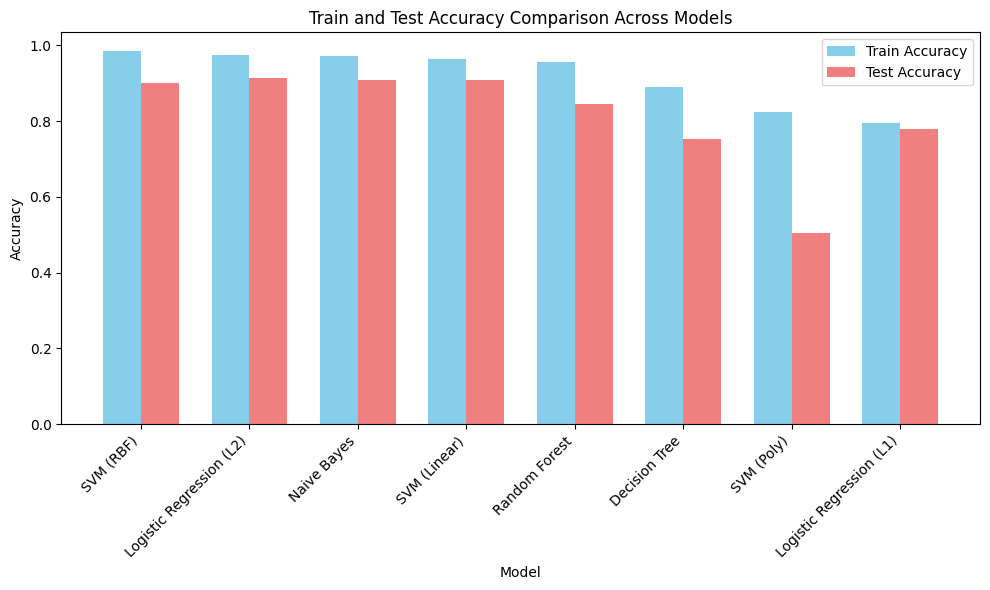

In [108]:
os.makedirs("Visualization", exist_ok=True)

vectorizer = joblib.load("Models/Vectorizer.joblib")

xtrain_tfidf = vectorizer.transform(train_texts)
xtest_tfidf = vectorizer.transform(test_texts)

print(f"Recomputed TF-IDF Matrix Shape (Train): {xtrain_tfidf.shape}")
print(f"Recomputed TF-IDF Matrix Shape (Test): {xtest_tfidf.shape}")

models = {
    'Logistic Regression (L1)': joblib.load('Models/LR_L1.joblib'),
    'Logistic Regression (L2)': joblib.load('Models/LR_L2.joblib'),
    'Naive Bayes': joblib.load('Models/NB.joblib'),
    'SVM (Linear)': joblib.load('Models/SVM_Linear.joblib'),
    'SVM (RBF)': joblib.load('Models/SVM_rbf.joblib'),
    'SVM (Poly)': joblib.load('Models/SVM_Poly.joblib'),
    'Decision Tree': joblib.load('Models/DT.joblib'),
    'Random Forest': joblib.load('Models/RF.joblib')
}

results = []
for model_name, sk_model in models.items():
    train_pred = sk_model.predict(xtrain_tfidf)
    test_pred = sk_model.predict(xtest_tfidf)
    train_accuracy = accuracy_score(train_labels, train_pred)
    test_accuracy = accuracy_score(test_labels, test_pred)
    results.append({
        'Model': model_name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Train Accuracy', ascending=False).reset_index(drop=True)

print("Model Accuracy Comparison (Sorted by Train Accuracy)")
display(results_df)

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(results_df))

plt.bar(index, results_df['Train Accuracy'], bar_width, label='Train Accuracy', color='skyblue')
plt.bar([i + bar_width for i in index], results_df['Test Accuracy'], bar_width, label='Test Accuracy', color='lightcoral')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy Comparison Across Models')
plt.xticks([i + bar_width / 2 for i in index], results_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('Visualization/model_accuracy_comparison.png')
plt.show()

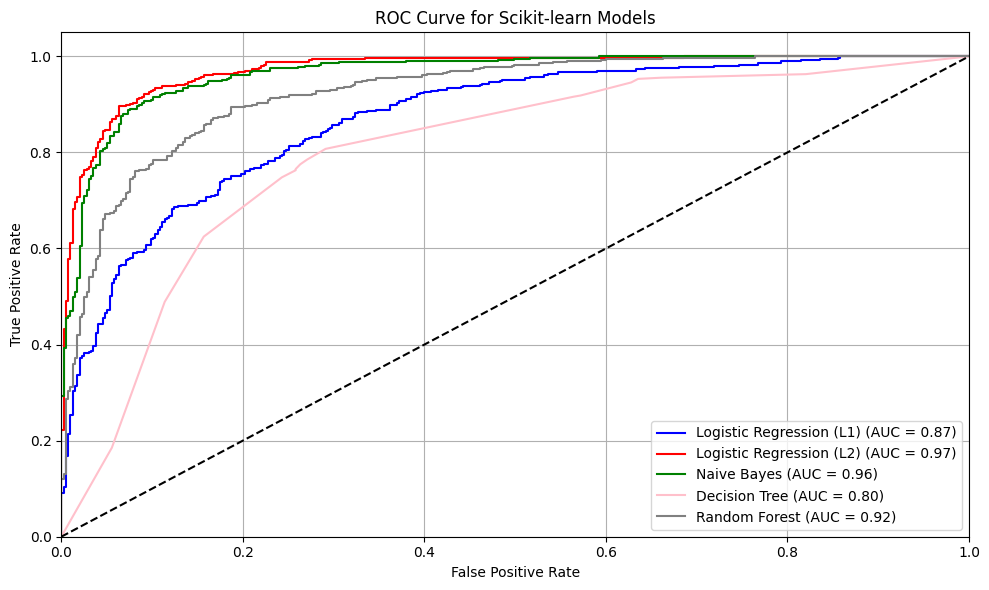

In [109]:
from sklearn.metrics import auc, roc_curve


plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']

for (model_name, sk_model), color in zip(models.items(), colors):
    if hasattr(sk_model, 'predict_proba'):
        probs = sk_model.predict_proba(xtest_tfidf)[:, 1]
        fpr, tpr, _ = roc_curve(test_labels, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', color=color)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Scikit-learn Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('Visualization/roc_curve_all_models.png')
plt.show()

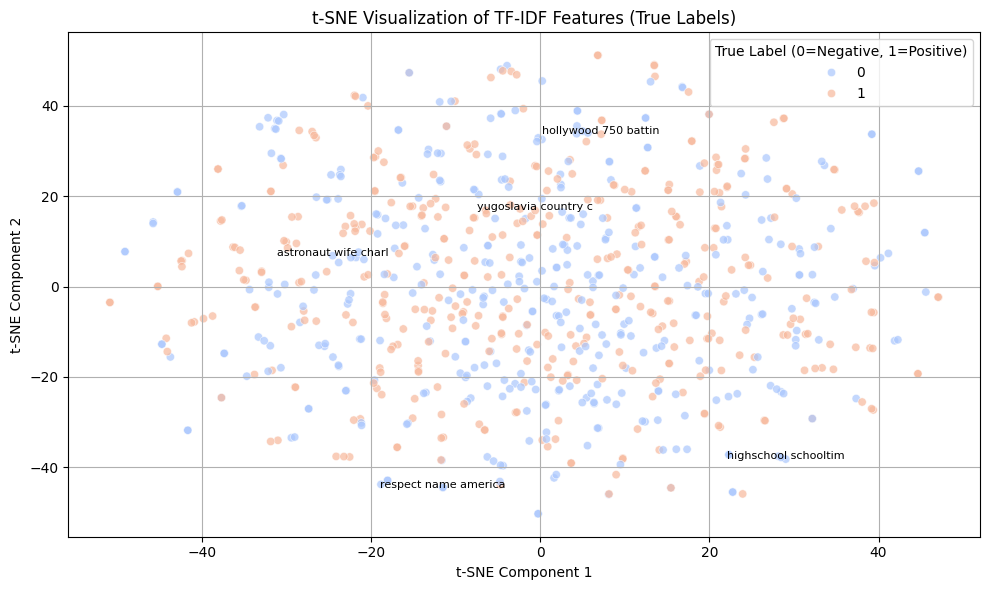

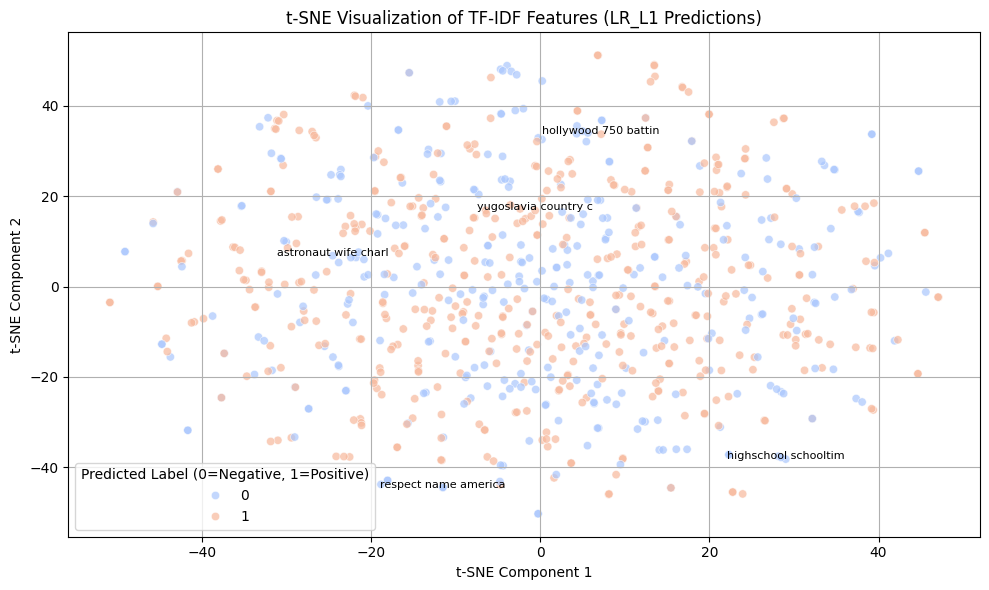

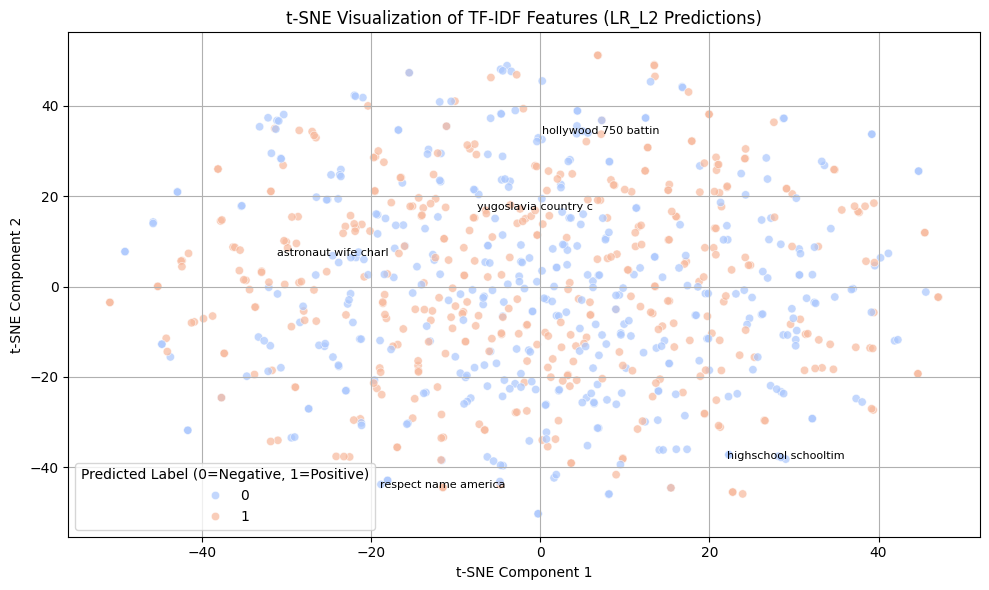

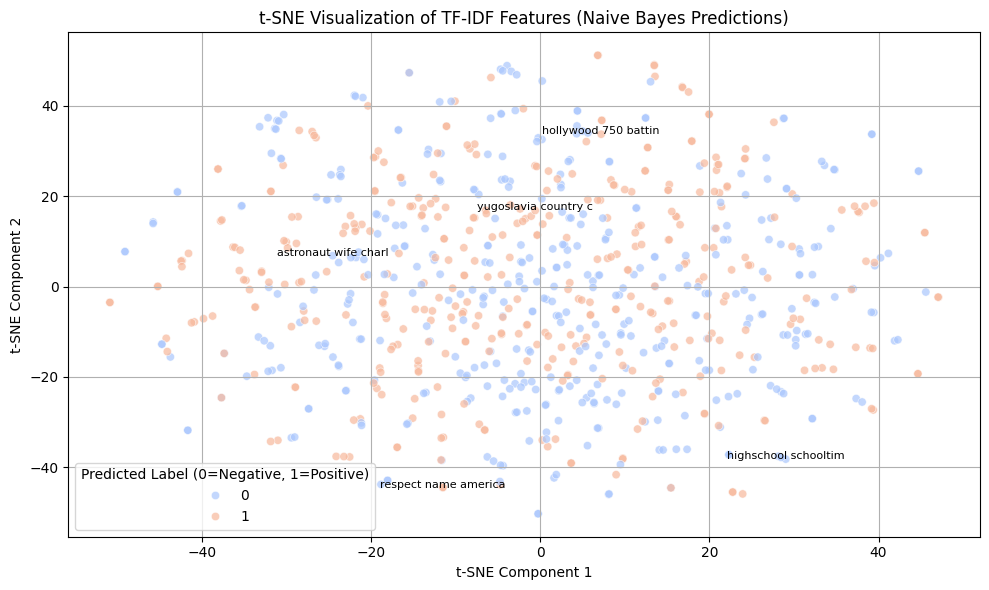

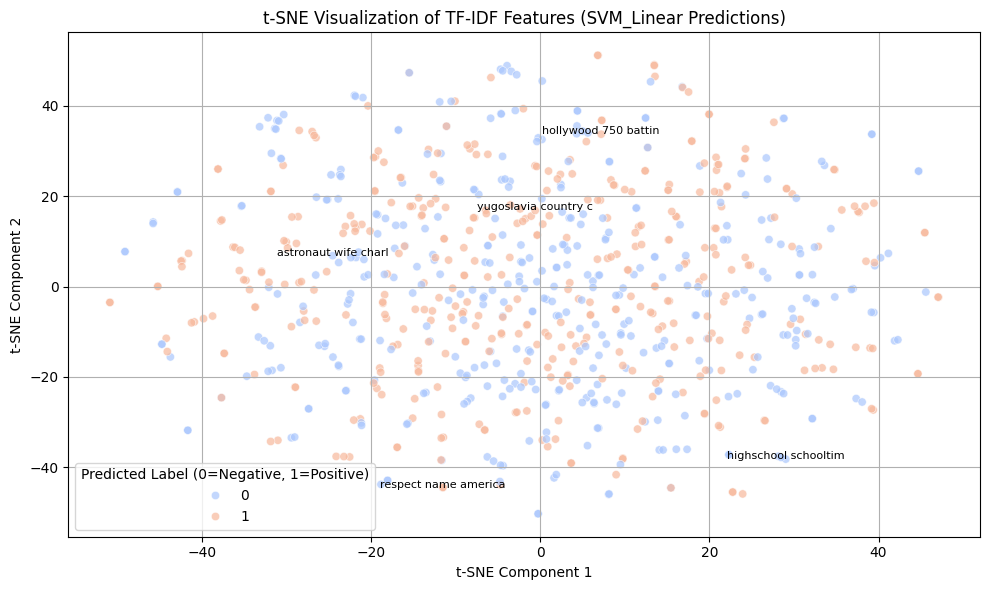

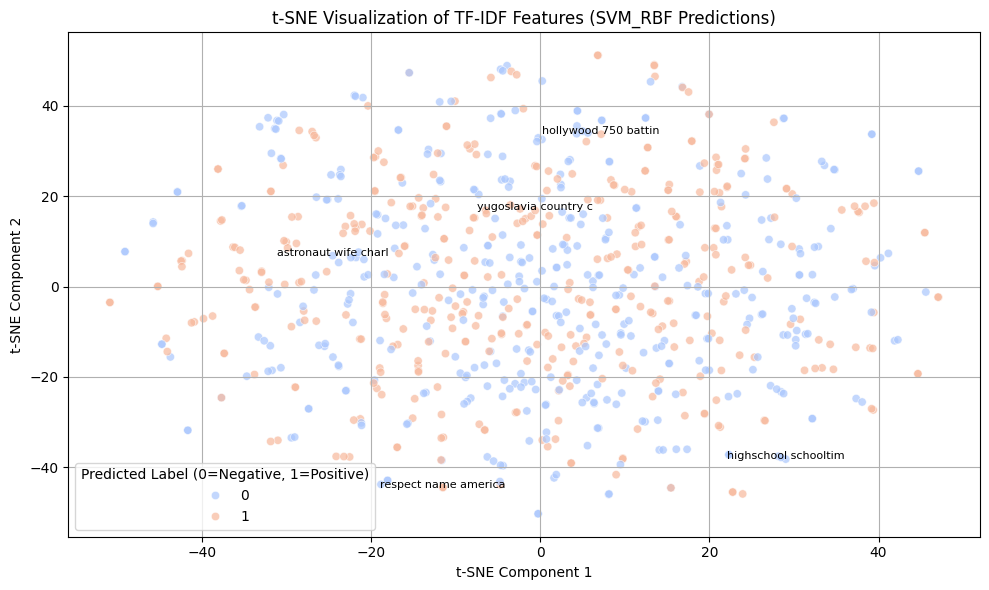

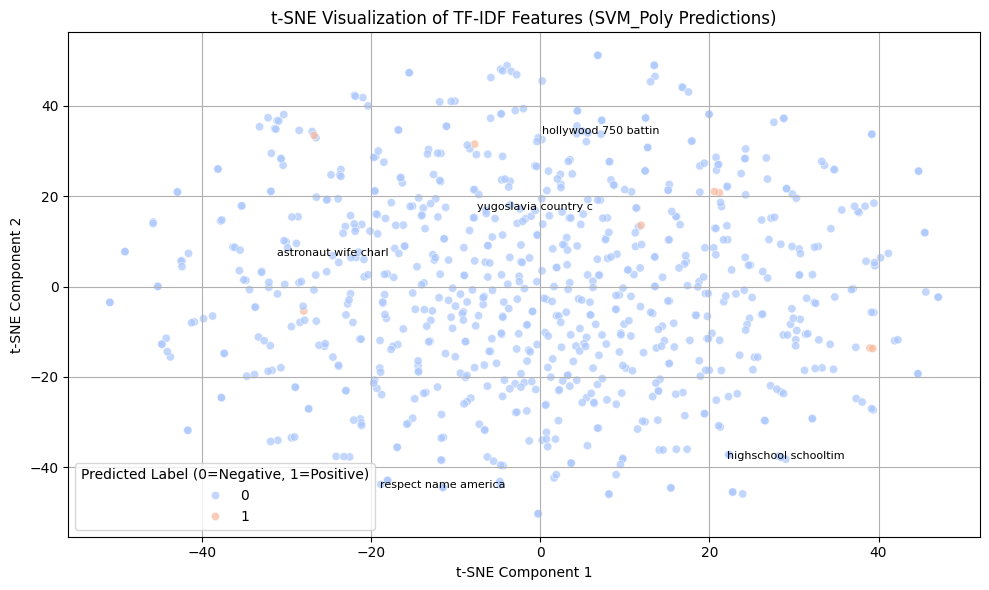

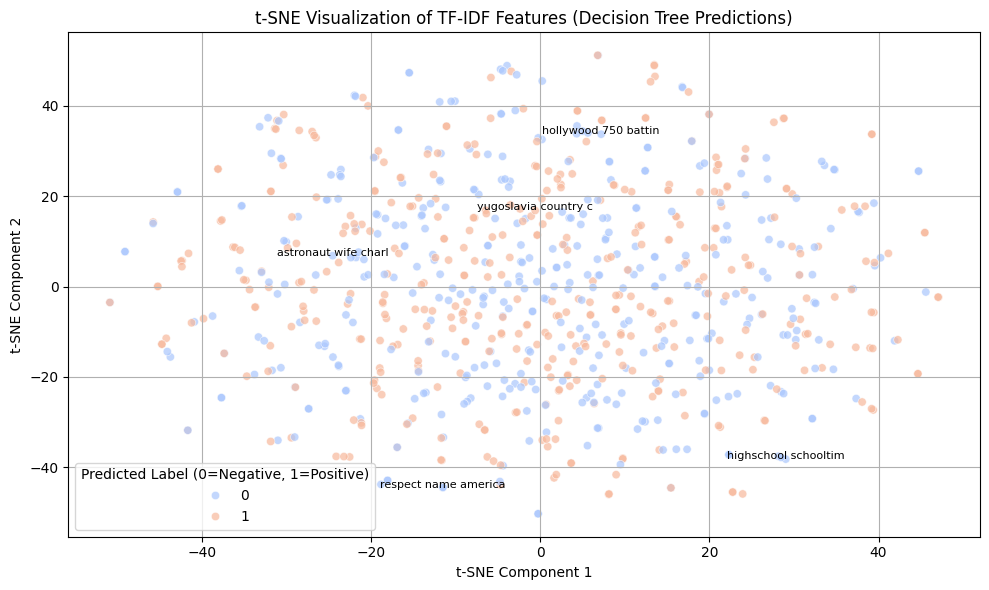

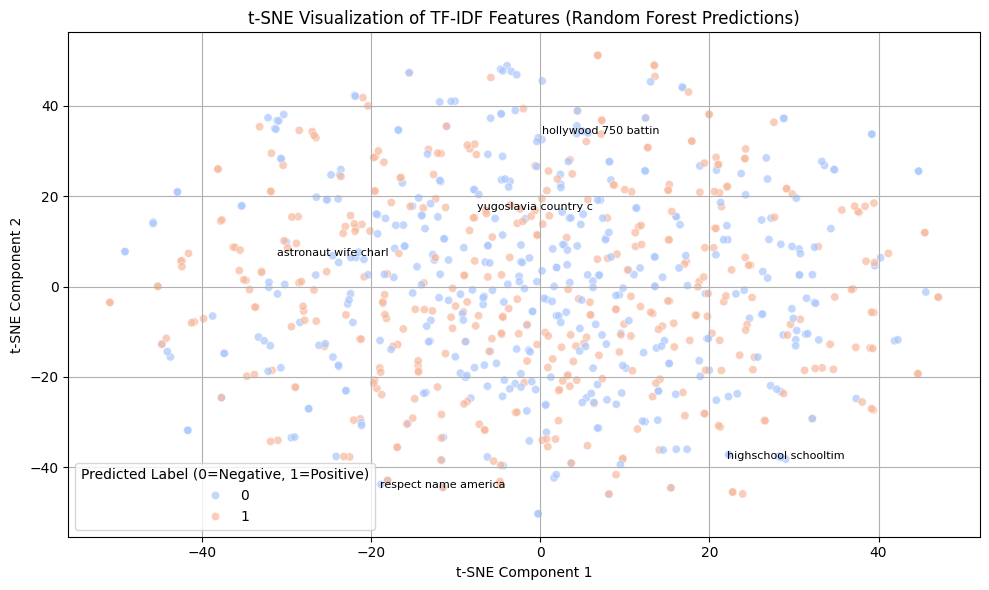

In [110]:
from sklearn.manifold import TSNE

model_files = {
    'LR_L1': 'Models/LR_L1.joblib',
    'LR_L2': 'Models/LR_L2.joblib',
    'Naive Bayes': 'Models/NB.joblib',
    'SVM_Linear': 'Models/SVM_Linear.joblib',
    'SVM_RBF': 'Models/SVM_rbf.joblib',
    'SVM_Poly': 'Models/SVM_Poly.joblib',
    'Decision Tree': 'Models/DT.joblib',
    'Random Forest': 'Models/RF.joblib'
}

tsne_tfidf = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1)
tsne_tfidf_results = tsne_tfidf.fit_transform(xtest_tfidf.toarray())

tsne_tfidf_df = pd.DataFrame({
    'TSNE1': tsne_tfidf_results[:, 0],
    'TSNE2': tsne_tfidf_results[:, 1],
    'True Label': test_labels
})

test_texts_reset = test_texts.reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='True Label', palette='coolwarm', data=tsne_tfidf_df, alpha=0.7)
plt.title('t-SNE Visualization of TF-IDF Features (True Labels)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='True Label (0=Negative, 1=Positive)', loc='best')
plt.grid(True)
plt.tight_layout()

np.random.seed(42)
for i in np.random.choice(len(test_texts_reset), 5, replace=False):
    plt.text(tsne_tfidf_df['TSNE1'].iloc[i], tsne_tfidf_df['TSNE2'].iloc[i], 
             test_texts_reset.iloc[i][:20], fontsize=8, ha='center')

plt.savefig('Visualization/tsne_tfidf_true.png')
plt.show()

for model_name, model_path in model_files.items():
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        
        predictions = model.predict(xtest_tfidf)
        tsne_tfidf_df['Predicted Label'] = predictions

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='TSNE1', y='TSNE2', hue='Predicted Label', palette='coolwarm', data=tsne_tfidf_df, alpha=0.7)
        plt.title(f't-SNE Visualization of TF-IDF Features ({model_name} Predictions)')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend(title='Predicted Label (0=Negative, 1=Positive)', loc='best')
        plt.grid(True)
        plt.tight_layout()

        np.random.seed(42)
        for i in np.random.choice(len(test_texts_reset), 5, replace=False):
            plt.text(tsne_tfidf_df['TSNE1'].iloc[i], tsne_tfidf_df['TSNE2'].iloc[i], 
                     test_texts_reset.iloc[i][:20], fontsize=8, ha='center')

        plt.savefig(f'Visualization/tsne_tfidf_{model_name.replace(" ", "_")}_predictions.png')
        plt.show()
    else:
        print(f"Model file {model_path} not found. Skipping {model_name}.")

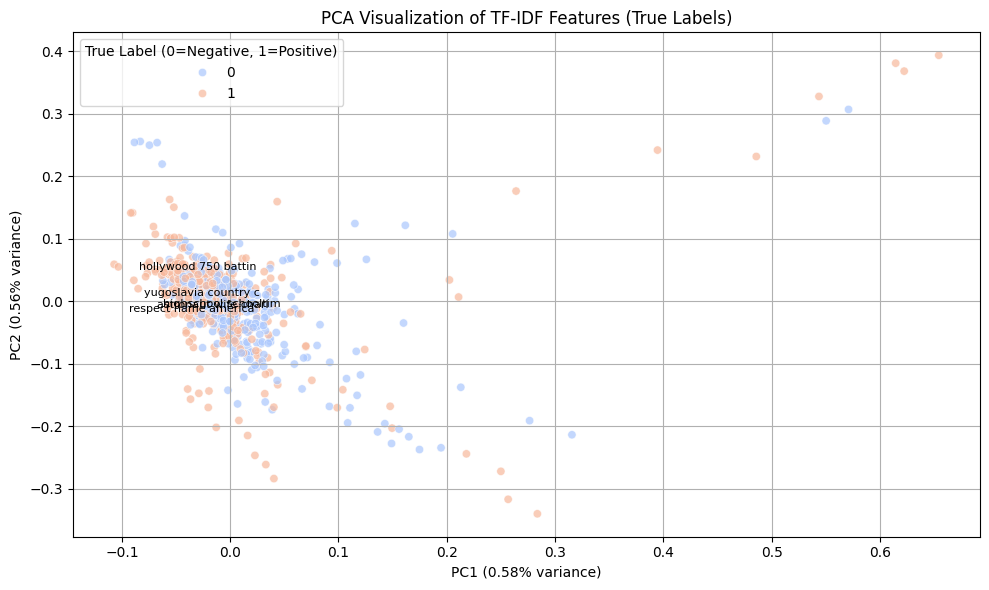

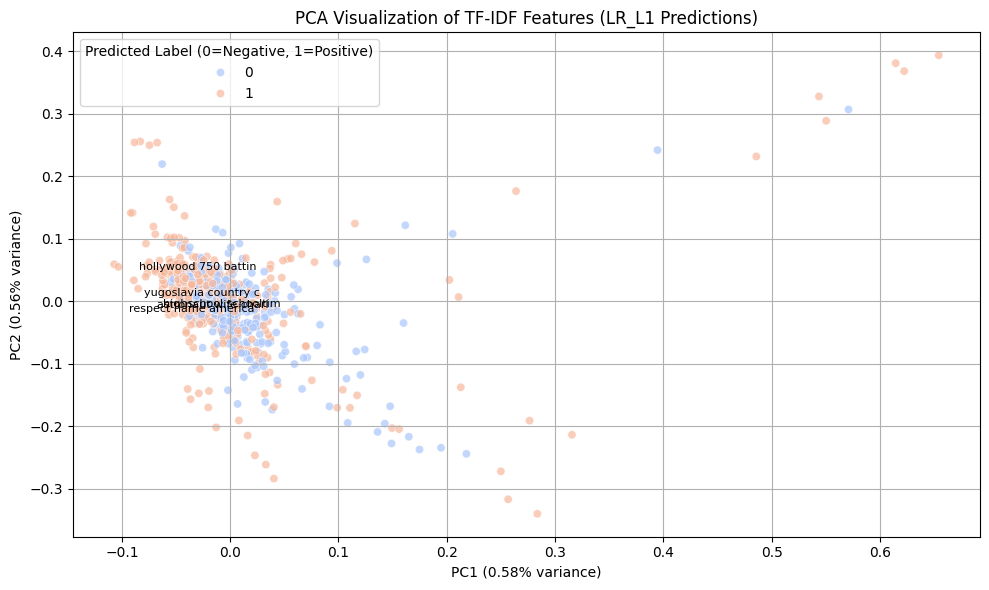

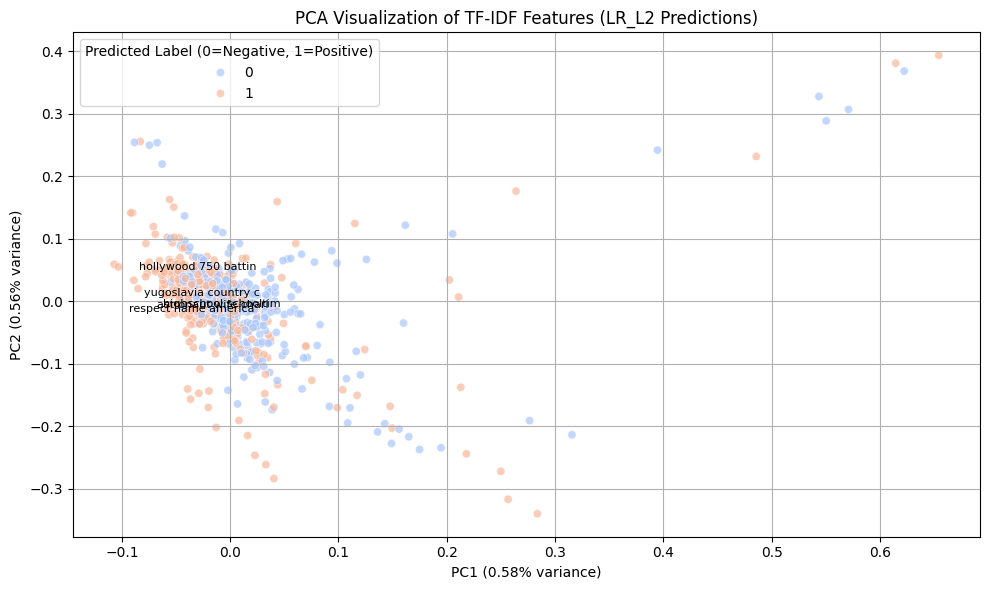

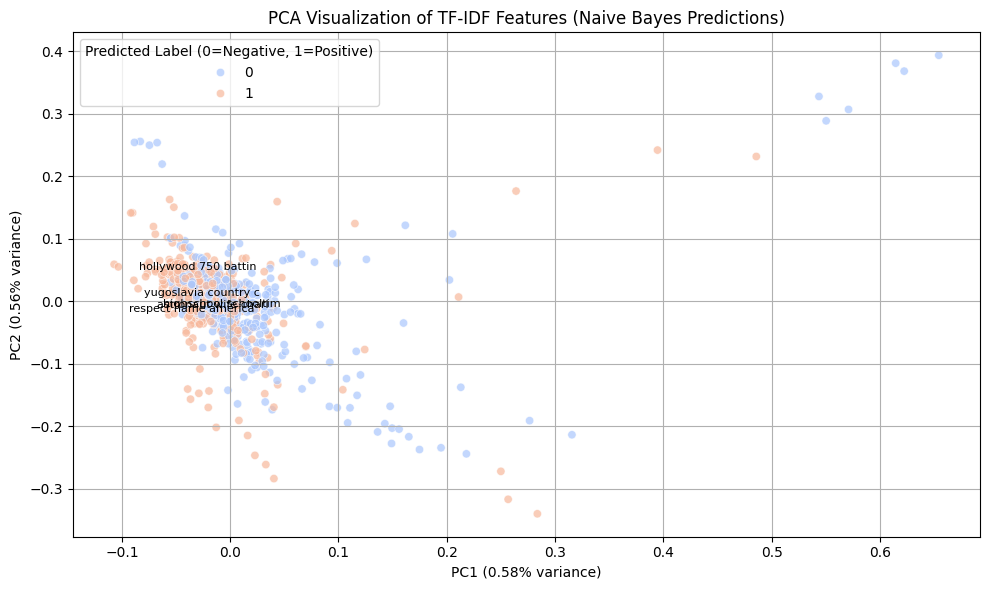

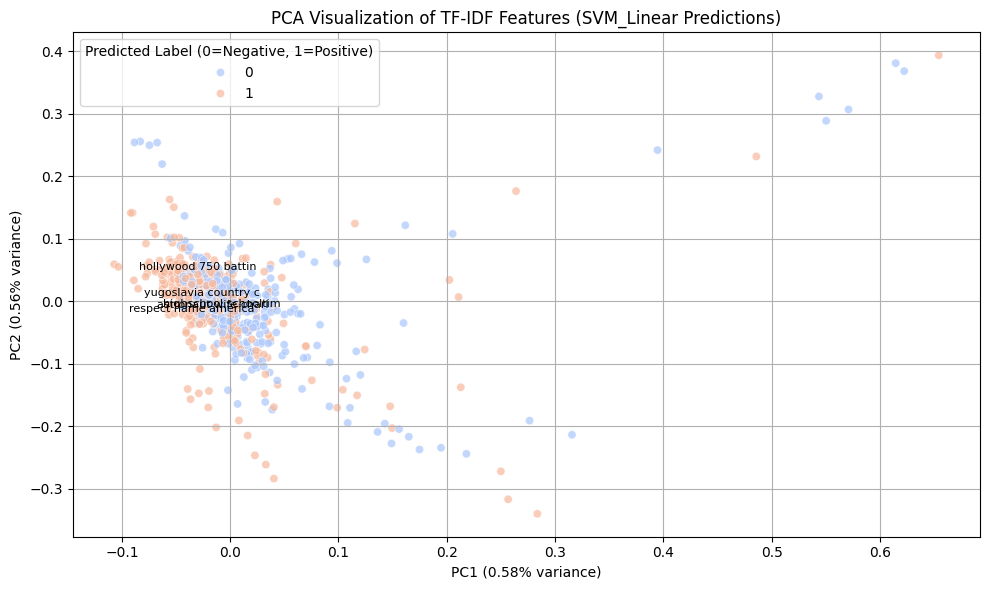

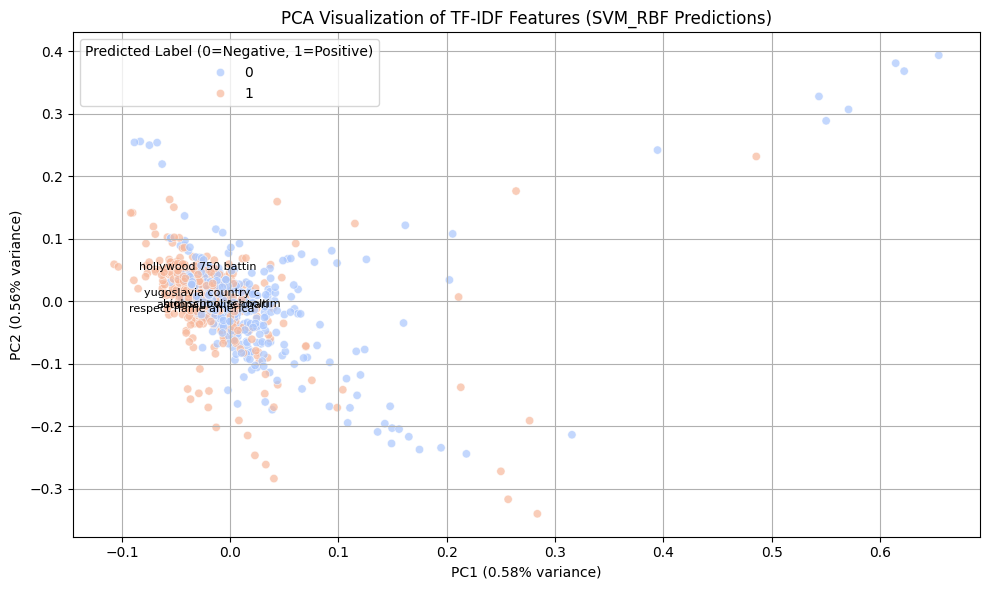

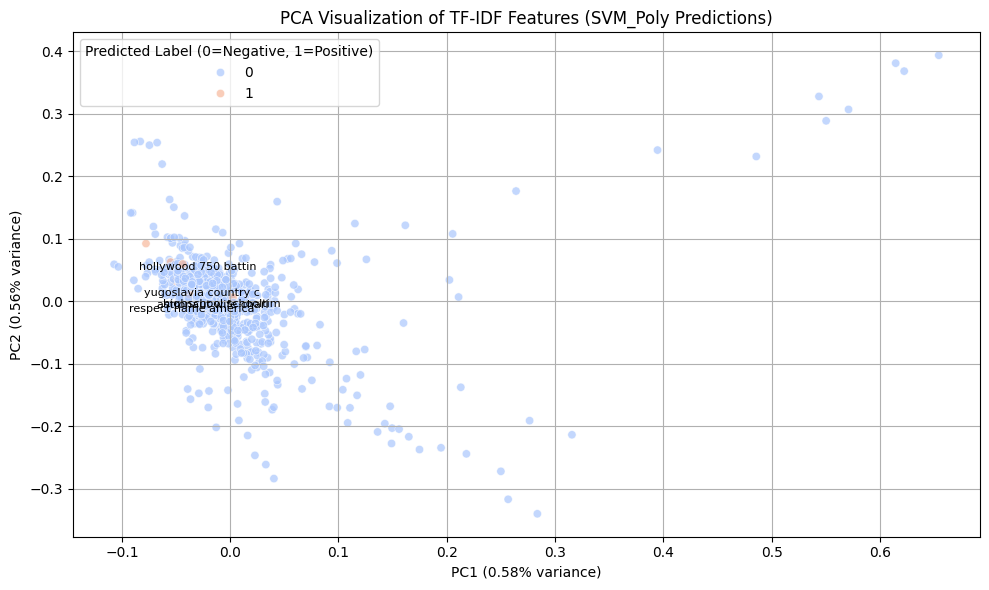

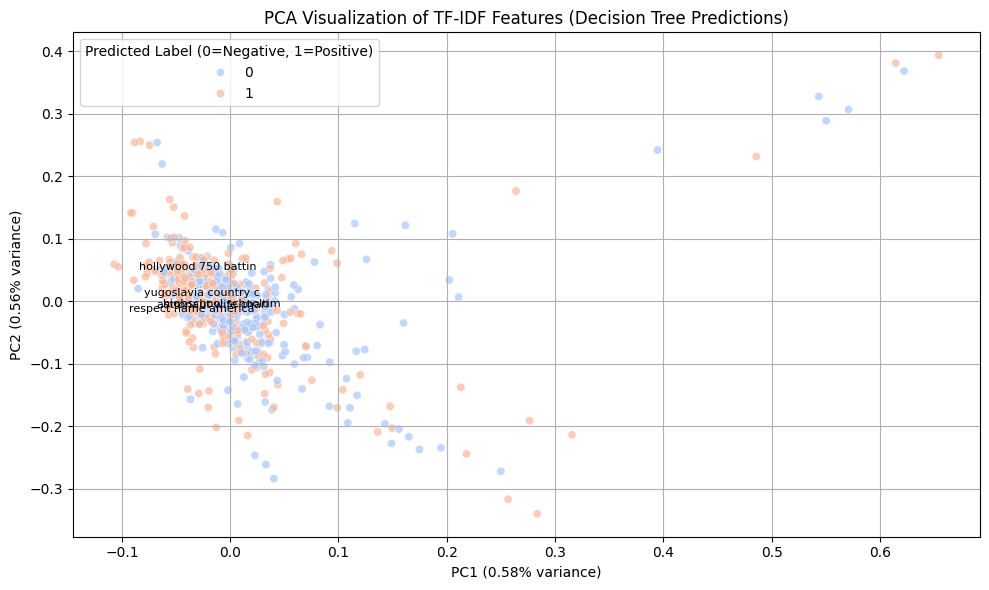

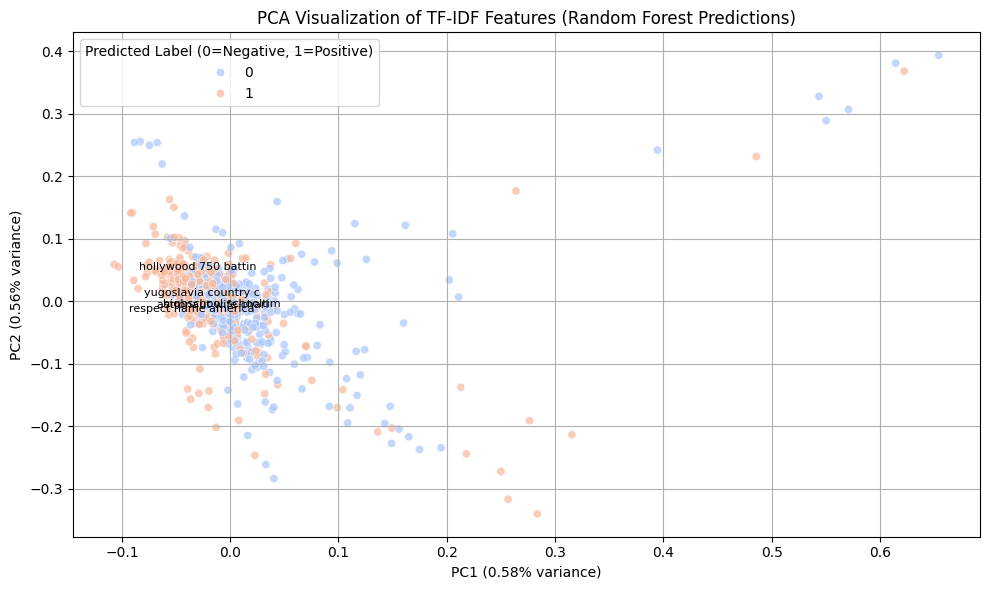

In [111]:
from sklearn.decomposition import PCA

pca_tfidf = PCA(n_components=2, random_state=42)
pca_tfidf_results = pca_tfidf.fit_transform(xtest_tfidf.toarray())

pca_tfidf_df = pd.DataFrame({
    'PC1': pca_tfidf_results[:, 0],
    'PC2': pca_tfidf_results[:, 1],
    'True Label': test_labels
})

test_texts_reset = test_texts.reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='True Label', palette='coolwarm', data=pca_tfidf_df, alpha=0.7)
plt.title('PCA Visualization of TF-IDF Features (True Labels)')
plt.xlabel(f'PC1 ({pca_tfidf.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_tfidf.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(title='True Label (0=Negative, 1=Positive)', loc='best')
plt.grid(True)
plt.tight_layout()

np.random.seed(42)
for i in np.random.choice(len(test_texts_reset), 5, replace=False):
    plt.text(pca_tfidf_df['PC1'].iloc[i], pca_tfidf_df['PC2'].iloc[i], 
             test_texts_reset.iloc[i][:20], fontsize=8, ha='center')

plt.savefig('Visualization/pca_tfidf_true.png')
plt.show()

for model_name, model_path in model_files.items():
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        
        predictions = model.predict(xtest_tfidf)
        pca_tfidf_df['Predicted Label'] = predictions

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='PC1', y='PC2', hue='Predicted Label', palette='coolwarm', data=pca_tfidf_df, alpha=0.7)
        plt.title(f'PCA Visualization of TF-IDF Features ({model_name} Predictions)')
        plt.xlabel(f'PC1 ({pca_tfidf.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca_tfidf.explained_variance_ratio_[1]:.2%} variance)')
        plt.legend(title='Predicted Label (0=Negative, 1=Positive)', loc='best')
        plt.grid(True)
        plt.tight_layout()

        np.random.seed(42)
        for i in np.random.choice(len(test_texts_reset), 5, replace=False):
            plt.text(pca_tfidf_df['PC1'].iloc[i], pca_tfidf_df['PC2'].iloc[i], 
                     test_texts_reset.iloc[i][:20], fontsize=8, ha='center')

        plt.savefig(f'Visualization/pca_tfidf_{model_name.replace(" ", "_")}_predictions.png')
        plt.show()
    else:
        print(f"Model file {model_path} not found. Skipping {model_name}.")